## Wstęp

Niniejszy notatnik zawiera zwięzłą opisową analizę danych o ofertach sprzedaży nieruchomości w Poznaniu zamieszczonych na stronie Otodom.pl wraz z symulacyjną analizą wpływu post-stratyfikacji na szacowanie średniej w próbach nielosowych.

Wybrany zbiór danych traktuje jako populację dla której znane są rozkłady zmiennej `Y` oraz zmiennych `X`

Na początku umożliwiam uruchamianie języka R w notatniku a także pobieram dane z repozytorium znajdującego się na githubie.

In [ ]:
%load_ext rpy2.ipython

In [ ]:
! git clone https://github.com/KrzysztofIgnasiak/Otodom

fatal: destination path 'Otodom' already exists and is not an empty directory.


Następnie pobieram i ładuje potrzebne biblioteki.

In [ ]:
%%R
install.packages("survey")
install.packages("lubridate")
install.packages("corrplot")
install.packages("scales")

In [ ]:
%%R
library(readxl)
library(dplyr)
library(lubridate)
library(ggplot2)
library(corrplot)
library(tidyr)
library(survey)
library (data.table)
library(scales)

## Ładowanie i przygotowywanie danych

Na początku pobieram dane do jednej centralnej tabeli `data frame`.

In [ ]:
%%R
## ładowanie danych
df1 = read_excel("Otodom/otodom_data1.xlsx")
df2 = read_excel("Otodom/otodom_data2.xlsx")
df3 = read_excel("Otodom/otodom_data3.xlsx")
df4 = read_excel("Otodom/otodom_data4.xlsx")

## konkatenacja
df <- rbind(df1,df2,df3,df4)

## zwalnianie poszczególnych tabel
rm(df1)
rm(df2)
rm(df3)
rm(df4)

Tabela posiada zmienną celu `Cena` oraz szereg zmiennych opisowych:
<br>
1. `Powierzchnia` określa całkowitą wielkość nieruchomości w metrach kwadratowych;
<br>
2. `Liczba Pokoi` oznacza liczbę pomieszczeń jakie znajdują się w nieruchomości;
<br>
3. `Rynek` określa czy nieruchomośc jest oferowana przez dewelopera czy pochodzi z rynku wtórnego;
<br>
4. `Rodzaj zabudowy` zawiera informacje o typie budynku w którym znajduje się nieruchomość;
<br>
5. `Piętro` oznacza numer piętra na którym znajduje się mieszkanie;
<br>
6. `Liczba pięter` zawiera informacje o całkowitej liczbie pięter w budynku;
7. `Okna` określa z jakiego materiału wykonane są okna w nieruchomości;
8. `Ogrzewanie` oznacza w jaki sposób mieszanie jest ogrzewane;
9. `Rok budowy` zawiera informacje o roku, w którym powstała/powstanie nieruchomość;
10. `Stan wykończenia ` określa czy mieszkanie jest gotowe do zamieszkania czy wymaga remontu/wykończenie itp.;
11. `Forma własności` informuje o formie własności, która jest przedmiotem oferty;
12. `Czynsz` oznacza wysokość comiesięcznego czynszu. 

Przed przeprowadzeniem analizy oraz symulacji konieczne jest odpowiednie przygotowanie danych.
Na początku przyporządkowuje tabeli nowe nazwy kolumn ze względu na wygodę.
Następnie usuwam wszystkie oferty, w których cena nie została ujawniona a także odpowiednio formatuje braki danych.

In [ ]:
%%R
names(df) <- c("Index","Square meters","Rooms","Market","Type","Floor","Number of floors","Windows","Heating","Year","Condition","Ownership","Rent","Price")
df = df[df$Price != 'Zapytaj o cenę',]
df = na_if(df, -1)

W dalszej kolejności należy sprowadzić kolumny do odpowiednich formatów.
 
Zaczynam od konwersji piętra, liczby pięter, liczby pokoi oraz roku na wartości numeryczne.

In [ ]:
%%R
df$Floor[df$Floor == "parter"] <- 0
df = transform(df, Floor = as.numeric(Floor))

df = transform(df, Rooms = as.numeric(Rooms))
df = transform(df, Number.of.floors = as.numeric(Number.of.floors))
df = transform(df, Year = as.numeric(Year))

Sprowadzam informacje o metrach kwadratowych do postaci numerycznej.

In [ ]:
%%R
##usunięcie przyrostka m^2
df$Square.meters =  gsub("([0-9]+,[0-9]+|[0-9]+) m.", "\\1", df$Square.meters)
## zmiana liczb w formacie 3,4 na 3.4
df$Square.meters = gsub(",",".",df$Square.meters)
df = transform(df, Square.meters = as.numeric(Square.meters))

Sprowadzam dane o cenach i wysokościach czynszu do postaci numerycznej.

In [ ]:
%%R
## usunięcie przerw w środku kwot
df$Price = gsub(" ","" ,df$Price)
## usunięcie przyrostka zł
df$Price = gsub("([0-9]+)zł","\\1", df$Price)
df = transform(df, Price = as.numeric(Price))

df$Rent = gsub(" ","" ,df$Rent)
df$Rent = gsub("([0-9]+)zł","\\1", df$Rent)
df = transform(df, Rent = as.numeric(Rent))


##Analiza Opisowa

Dokonuje waryfikacji częstości występowania braków danych z podziałem na poszczególne kolumny.

In [ ]:
%%R
NaInfo <- as.data.frame(sapply(df, function(x) sum(is.na (x))))

NaInfo <- cbind(newColName = rownames(NaInfo), NaInfo)
rownames(NaInfo) <- 1:nrow(NaInfo)

names(NaInfo) <- c("Feature","Count")

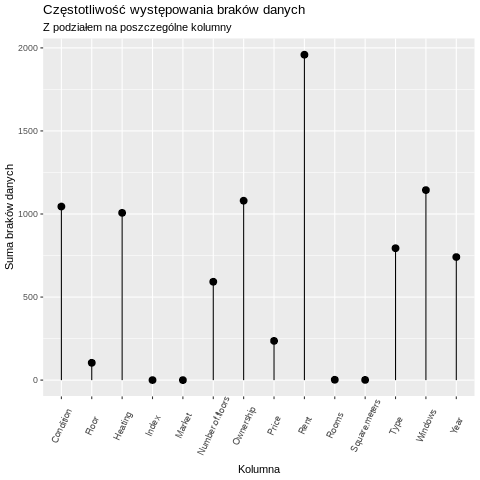

In [ ]:
%%R
ggplot(NaInfo, aes(x=Feature, y=Count)) + 
  geom_point(size=3) + 
  geom_segment(aes(x=Feature, 
                   xend=Feature, 
                   y=0, 
                   yend=Count)) + 
  labs(title="Częstotliwość występowania braków danych", 
       subtitle="Z podziałem na poszczególne kolumny",x = "Kolumna", y = "Suma braków danych") + 
  theme(axis.text.x = element_text(angle=65, vjust=0.6))

W zbiorze danych niezwykle często występują braki danych.
<br>
Zaskakujące jest, że tak kluczowa informacja jak wysokość czynszu bardzo często nie jest ujawniana.
<br>
Z dalszej analizy zostaną usunięte oferty, które nie zawierają informacji o cenie, liczbie pokoi i wielkości nieruchomości.

In [ ]:
%%R
df <- df %>% drop_na(Price)
df <- df %>% drop_na(Square.meters)
df <- df %>% drop_na(Rooms)

Oszacowuje kolerację pomiędzy zmiennymi ilościowymi.

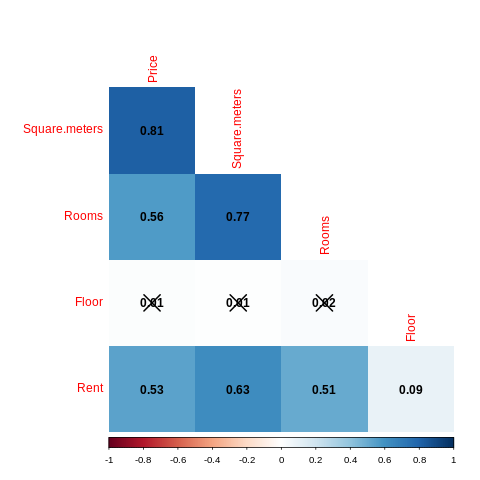

In [ ]:
%%R
numericalFeatures <- select(df, Price, Square.meters, Rooms,Floor,Rent)
corr <- cor(numericalFeatures,  method = "pearson", use = "complete.obs")

res1 <- cor.mtest(numericalFeatures, conf.level = .95)

corrplot(corr, p.mat = res1$p, method = "shade", type = "lower",
         addCoef.col ='black', diag=FALSE)

Zmienna celu tj. Cena jest isotnie skolerowana z wielkością mieszkania oraz liczbą pokoi. Istotny wpływ ma także wysokość czynsu, lecz należy mieć na uwadzę, że informacja ta zaskakująco często nie jest podawana.

Nasuwa się pytanie w jakim stanie i z jakiego rynku(pierwotny, wtórny) jest większość ofert.

In [ ]:
%%R

# zliczanie ofert z poszczególnego rynku
Market_count <- df %>%
     group_by(Market) %>% 
     tally()

Market_count <- Market_count %>%
  mutate_if(is.numeric, funs(./sum(.))) 

# umieszczanie etykiety w centrum danego kawałka wykresu
  Market_count <- Market_count %>%
  arrange(desc(Market)) %>%
  mutate(lab.ypos = cumsum(n) - 0.5*n)

#zliczanie ofert charakteryzujących się poszczególnym stanem
 Condition_Count <- df %>%
     group_by(Condition) %>% 
     tally()  

Condition_Count <- Condition_Count %>%
  mutate_if(is.numeric, funs(./sum(.))) 

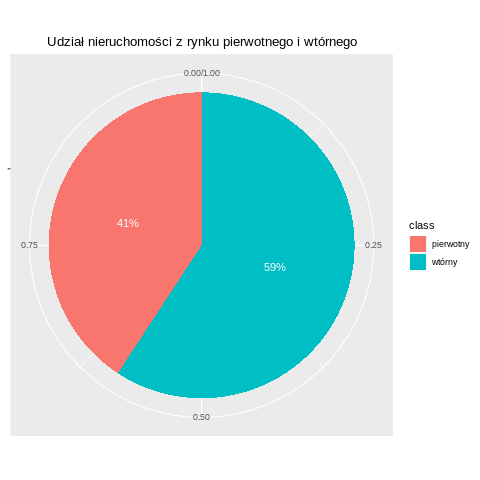

In [ ]:
%%R
pie <- ggplot(Market_count, aes(x = "", y=n, fill = factor(Market))) + 
  geom_bar(width = 1, stat = "identity") +
  coord_polar(theta = "y", start=0) +
  geom_text(aes(y = lab.ypos, label = percent(n)), color = "white")+
  theme(axis.line = element_blank(), 
        plot.title = element_text(hjust=0.5)) + 
  labs(fill="class", 
       x=NULL, 
       y=NULL, 
       title="Udział nieruchomości z rynku pierwotnego i wtórnego")

pie 

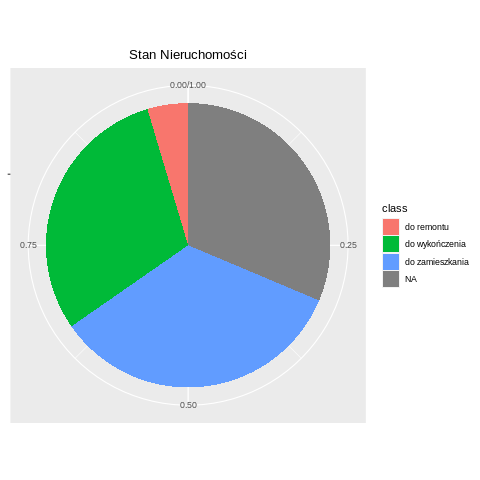

In [ ]:
%%R
pie <- ggplot(Condition_Count, aes(x = "", y=n, fill = factor(Condition))) + 
  geom_bar(width = 1, stat = "identity") +
  theme(axis.line = element_blank(), 
        plot.title = element_text(hjust=0.5)) + 
  labs(fill="class", 
       x=NULL, 
       y=NULL, 
       fill = "# Stan Nieruchomości",
       title="Stan Nieruchomości")

pie + coord_polar(theta = "y", start=0)

Ponad 40 % ofert stanowią nowe mieszkania oraz domy budowane przez deweloperów. Świadczy to o szybkim rozwoju urbanistyki na terenie Poznania. 
<br>
Jednocześnie tylko przy relatywnie niewielkiej ilości ofert znajduje się informacja o tym, że są w stanie do remontu. 
<br>
Mając to na uwadzę przy jednoczesnym podkreśleniu znacznej ilości braków danych można podejrzewać, że sprzedający są niechętni do ujawniania informacji o potrzebie remontu.

Badam popularność mieszkań pod względem liczby pokoi.

In [ ]:
# zliczanie ofert charakteryzujący się poszczególną liczbą pokoi
%%R
Rooms_count <- df %>%
     group_by(Rooms) %>% 
     tally()

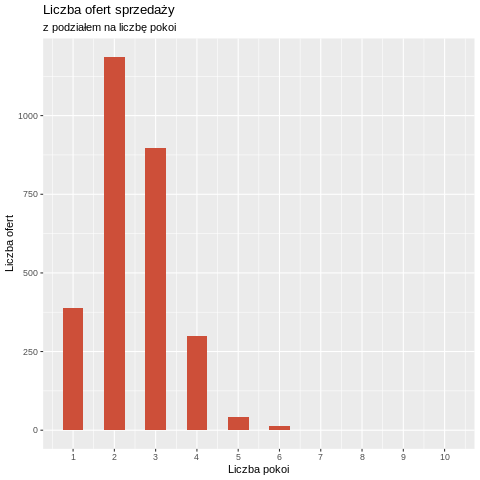

In [ ]:
%%R
ggplot(Rooms_count, aes(x=Rooms, y=n))+ 
  geom_bar(stat="identity", width=.5, fill="tomato3")+
  labs(title="Liczba ofert sprzedaży", 
       subtitle="z podziałem na liczbę pokoi", x = "Liczba pokoi", y= "Liczba ofert") + 
  scale_x_continuous(breaks = seq(1, 10, by = 1))

Warto zauważyć, że zdecydowanie najpopularniejsze są małe mieszkania choć niekoniecznie kawalerki.

Badam liczbę ofert z podziałem na poszczególne dekady.

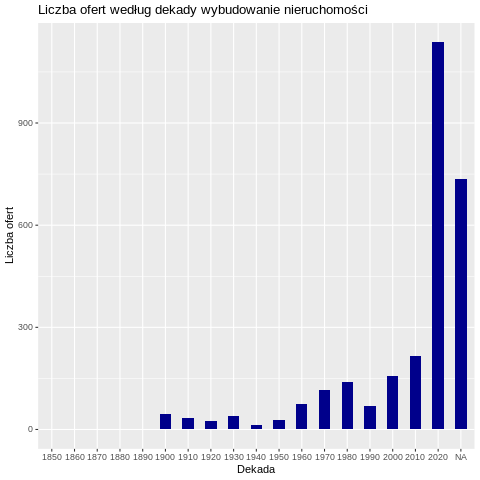

In [ ]:
%%R
floor_decade    = function(value){ return(value - value %% 10) }
df = transform(df, Year = as.numeric(Year))
df$Decade <- mapply(floor_decade, df$Year)
df$Decade[df$Decade == 20202020] <- 2020

c <- ggplot(df, aes(factor(Decade)))
c + geom_bar(width=.5, fill="blue4")+
  labs(title="Liczba ofert według dekady wybudowanie nieruchomości", x = "Dekada", y ="Liczba ofert") 

Można zauważyć, że zdecydowana większość ofert dotyczy relatywnie niedawno wbyduowanych nieruchomości.

Analizuję cenę za metr kwadratowy z podziałem na liczbę pokoi. Nieruchomości posiadające więcej niż 6 pokoi nie zostały uwzględnione ze względu na niewystarczająca reprezentację w zbiorze danych.

In [ ]:
%%R
#Tworzę nową kolumnę zawierającą cenę za metr kwadratowy
df$PricePerM <- with(df, Price/Square.meters)

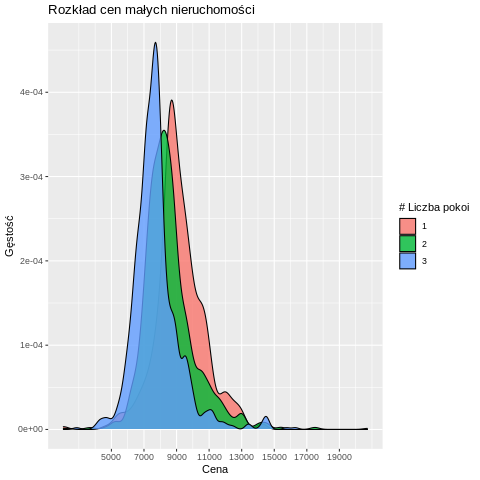

In [ ]:
%%R
g <- ggplot(df[df$Rooms < 4 ,], aes(PricePerM))
g + geom_density(aes(fill=factor(Rooms)), alpha=0.8) + 
    labs(title="Rozkład cen małych nieruchomości",
         x="Cena",
         y = "Gęstość",
         fill="# Liczba pokoi") +
           scale_x_continuous(breaks = seq(5000, 20000, by = 2000))

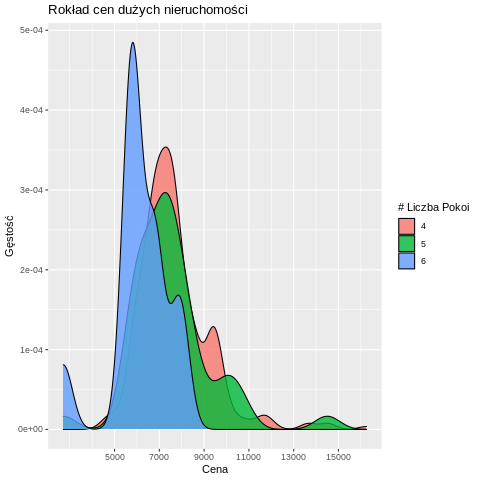

In [ ]:
%%R
g <- ggplot(df[df$Rooms < 7 & df$Rooms>=4 ,], aes(PricePerM))
g + geom_density(aes(fill=factor(Rooms)), alpha=0.8) + 
    labs(title="Rokład cen dużych nieruchomości",
         x="Cena",
         y = "Gęstość",
         fill="# Liczba Pokoi")+
         scale_x_continuous(breaks = seq(5000, 20000, by = 2000))

Można zauważyć, że wraz ze wzrostem liczby pokoi cena za metr kwadratowy maleje.

##Badanie Symulacyjne

Przypisuję wszystkim obserwacją wagę równą 1. Kolumna ta będzie potrzeba przy dokonywaniu kalibracji.

In [ ]:
%%R
df <- df %>%
  mutate(Weight = 1)

Obliczam prawdziwą wartość średniej.

In [ ]:
%%R
cena_prawdziwa <- mean(df$Price)
cena_prawdziwa

[1] 439380.9


Dokonuje symulacji.

In [ ]:
%%R
B <- 100
wyniki_naiwny <- numeric(B)
wyniki_ps <- numeric(B)
total_rows <- nrow(df)

## wartości globalne
global <- xtabs(~ Rooms, data = df)

for (b in 1:B) {
  set.seed(b) ## pełna replikacja, a poniżej losowanie próby
  nielos_id <- sample(x = 1:total_rows, size = 0.2*total_rows, 
                      prob = df$Square.meters/sum(df$Square.meters))
  ## wybieram rekordy
  nielosowa <- df[nielos_id, ]
  ## wyliczam estymator naiwny
  wyniki_naiwny[b] <- mean(nielosowa$Price)
  ## przygotowanie do post-stratyfikcji
  svydes <- svydesign(ids = ~1, data = nielosowa, weights = ~1)
  ## post-stratyfikacja
  svydes_post <- postStratify(svydes, ~Rooms, global,partial = TRUE)
  ## wyliczam estymator post-stratyfikacyjny
  wyniki_ps[b] <- svymean(~ Price, svydes_post)[1]

}

In [ ]:
%%R
wyniki <- data.frame(naive_oczekiwana = mean(wyniki_naiwny), 
                     naive_odchyl = sd(wyniki_naiwny), 
                     naive_obciazenie = mean(wyniki_naiwny) - cena_prawdziwa,
                     post_oczekiwana = mean(wyniki_ps), 
                     post_odchyl = sd(wyniki_ps), 
                     post_obciazenie = mean(wyniki_ps) - cena_prawdziwa,
                     cena_prawdziwa = cena_prawdziwa
)
wyniki


  naive_oczekiwana naive_odchyl naive_obciazenie post_oczekiwana post_odchyl
1         494080.9     8489.348         54699.96        461820.9    6762.227
  post_obciazenie cena_prawdziwa
1           22440       439380.9


Zastosowanie post-stratyfikacji znacznie zmniejszyło odchylenie standardowe i obciążenia estymator. Można stwierdzić, że wykorzystanie tej metody uczyniło oszacowanie wiarygodnym.